# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Load data](#Load-data)
* [Setup](#Setup)
* [Evaluate](#Evaluate)
  * [By speaker gender](#By-speaker-gender)
  * [By language](#By-language)
  * [By valence (OvR)](#By-valence-(OvR))
  * [One English sample](#One-English-sample)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

We have now trained 4 prototypes on features engineered from FRILL embeddings. In addition, we have extracted the same features from holdout data from three new sources. In this notebook, we evaluate the classification performance of the prototypes on the unseen data.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from gc import collect as gc_collect
from joblib import dump, load

from tqdm.notebook import tqdm

# typing
from typing import Callable, Dict, List

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    top_k_accuracy_score,
)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.49 s


In [4]:
# Location of holdout data
HOLDOUT_DATA = "../21.0-mic-prepare_holdout_datasets_for_evaluation"

# Location where this notebook will output
OUT_FOLDER = "."

# Location of prototype joblib files
PROTOTYPES = "../20.0-mic-tune_and_train_prototypes/prototypes"

_ = gc_collect()

time: 99.6 ms


# Load data

In [5]:
data = pd.read_feather(f"{HOLDOUT_DATA}/holdout_featurized.feather")
labels = pd.read_feather(f"{HOLDOUT_DATA}/holdout_labels.feather")
y_true = labels.valence

time: 35 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [6]:
MODELS = (
    "bagging_GNB",
    "plain_GNB",
    "randomforest",
    "voting_ensemble",
    "voting_ensemble_gnb_ridge",
    "ridge",
)
load_model = lambda model: load(f"{PROTOTYPES}/{model}.joblib")

# ternary to binary labels per class
RECODER = {
    "neg": lambda y: ((y - 1) // 2) * (-1),
    "neu": lambda y: y % 2,
    "pos": lambda y: y // 2,
}

VALENCE = {"neg": 0, "neu": 1, "pos": 2}


def binary_scorer(scorer: Callable, valence: str) -> Callable:
    "Returns a binary scorer for the given class (valence)"

    def new_scorer(y_true, y_score) -> float:
        y_true = RECODER[valence](y_true)
        y_score = RECODER[valence](np.squeeze(y_score))
        try:  # for predict_proba output
            _ = len(y_score[0])  # len(int) should throw a TypeError
            y_score: np.ndarray = y_score[:, VALENCE[valence]]
        except TypeError:
            y_score = RECODER[valence](y_score)
        return scorer(y_true, y_score)

    return new_scorer


METRICS = {
    "accuracy": accuracy_score,
    "adjusted_balanced_accuracy": lambda y_true, y_pred: balanced_accuracy_score(
        y_true, y_pred, adjusted=True
    ),
    "balanced_accuracy": balanced_accuracy_score,  # default
    "macro_f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"),
    "micro_f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average="micro"),
    "weighted_f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
    "macro_precision": lambda y_true, y_pred: precision_score(
        y_true, y_pred, average="macro"
    ),
    "micro_precision": lambda y_true, y_pred: precision_score(
        y_true, y_pred, average="micro"
    ),
    "weighted_precision": lambda y_true, y_pred: precision_score(
        y_true, y_pred, average="weighted"
    ),
    "macro_recall": lambda y_true, y_pred: recall_score(
        y_true, y_pred, average="macro"
    ),
    "micro_recall": lambda y_true, y_pred: recall_score(
        y_true, y_pred, average="micro"
    ),
    "weighted_recall": lambda y_true, y_pred: recall_score(
        y_true, y_pred, average="weighted"
    ),
    "geometric_mean": lambda y_true, y_pred: geometric_mean_score(
        y_true, y_pred, average="multiclass"
    ),
    "macro_geometric_mean": lambda y_true, y_pred: geometric_mean_score(
        y_true, y_pred, average="macro"
    ),
    "micro_geometric_mean": lambda y_true, y_pred: geometric_mean_score(
        y_true, y_pred, average="micro"
    ),
    # the below require .predict_proba output
    "auroc_macro_ovo": lambda y_true, y_score: roc_auc_score(
        y_true, y_score, average="macro", multi_class="ovo"
    ),
    "auroc_macro_ovr": lambda y_true, y_score: roc_auc_score(
        y_true, y_score, average="macro", multi_class="ovr"
    ),
    "auroc_weighted_ovo": lambda y_true, y_score: roc_auc_score(
        y_true, y_score, average="weighted", multi_class="ovo"
    ),
    "auroc_weighted_ovr": lambda y_true, y_score: roc_auc_score(
        y_true, y_score, average="weighted", multi_class="ovr"
    ),
    "log_loss": log_loss,
    "top_2_accuracy": top_k_accuracy_score,
    # the below must be adapted to multiclass and require .predict_proba output
    "average_precision_neg": binary_scorer(
        lambda y_true, y_score: average_precision_score(
            y_true, y_score, average="weighted"
        ),
        "neg",
    ),
    "average_precision_neu": binary_scorer(
        lambda y_true, y_score: average_precision_score(
            y_true, y_score, average="weighted"
        ),
        "neu",
    ),
    "average_precision_pos": binary_scorer(
        lambda y_true, y_score: average_precision_score(
            y_true, y_score, average="weighted"
        ),
        "pos",
    ),
    "brier_loss_neg": binary_scorer(brier_score_loss, "neg"),
    "brier_loss_neu": binary_scorer(brier_score_loss, "neu"),
    "brier_loss_pos": binary_scorer(brier_score_loss, "pos"),
}
PREDICT_PROBA_KEYS = {
    "auroc_macro_ovo",
    "auroc_macro_ovr",
    "auroc_weighted_ovo",
    "auroc_weighted_ovr",
    "log_loss",
    "top_2_accuracy",
    "average_precision_neg",
    "average_precision_neu",
    "average_precision_pos",
    "brier_loss_neg",
    "brier_loss_neu",
    "brier_loss_pos",
}

results = {
    "model": [],
    "score_set": [],
    **{metric: [] for metric in METRICS.keys()},
}

GNB_FEATURES = ["spherical-LDA1", "spherical-LDA2"]


def score_model(
    model_name: str, score_set: str, data: pd.DataFrame, results: Dict[str, List]
) -> Dict[str, List]:
    """Score a fitted model using METRICS and record in results"""
    results["model"].append(model_name)
    results["score_set"].append(score_set)
    model = load_model(model_name)
    if "GaussianNB" in str(model):
        data = data.loc[:, GNB_FEATURES]
    y_true_ = labels.loc[data.index, "valence"]
    y_pred = model.predict(data)
    y_prob = model.predict_proba(data)
    dump(y_prob, f"{OUT_FOLDER}/predictions/{model_name}_{score_set}.pkl")
    for metric, scorer in tqdm(METRICS.items()):
        try:
            results[metric].append(
                scorer(y_true_, y_prob if metric in PREDICT_PROBA_KEYS else y_pred)
            )
        except ValueError as e:
            print(e)
            results[metric].append(np.nan)
    return results


_ = gc_collect()

time: 105 ms


# Evaluate

In [7]:
for model in tqdm(MODELS):
    results = score_model(model, "all3", data, results)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names,

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

time: 13.9 s


In [8]:
results_df = pd.DataFrame(results)
for metric in METRICS.keys():
    print(
        results_df.loc[
            results_df[metric]
            == (
                results_df[metric].min()
                if "loss" in metric
                else results_df[metric].max()
            ),
            ["model", metric],
        ]
    )

                       model  accuracy
4  voting_ensemble_gnb_ridge  0.593255
                       model  adjusted_balanced_accuracy
4  voting_ensemble_gnb_ridge                    0.075042
                       model  balanced_accuracy
4  voting_ensemble_gnb_ridge           0.383361
                       model  macro_f1
4  voting_ensemble_gnb_ridge  0.354838
                       model  micro_f1
4  voting_ensemble_gnb_ridge  0.593255
                       model  weighted_f1
4  voting_ensemble_gnb_ridge     0.497042
         model  macro_precision
0  bagging_GNB         0.543895
1    plain_GNB         0.543895
                       model  micro_precision
4  voting_ensemble_gnb_ridge         0.593255
         model  weighted_precision
0  bagging_GNB             0.56474
1    plain_GNB             0.56474
                       model  macro_recall
4  voting_ensemble_gnb_ridge      0.383361
                       model  micro_recall
4  voting_ensemble_gnb_ridge      0.593255
       

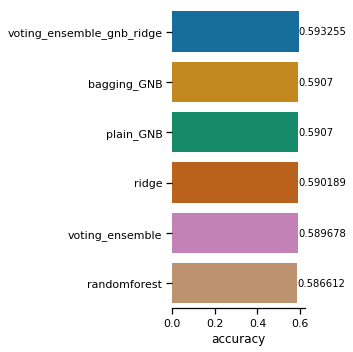

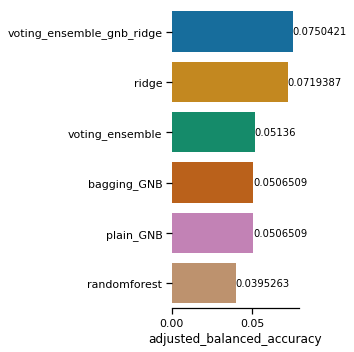

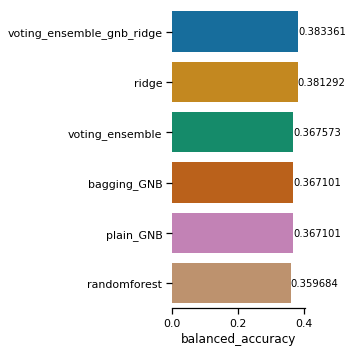

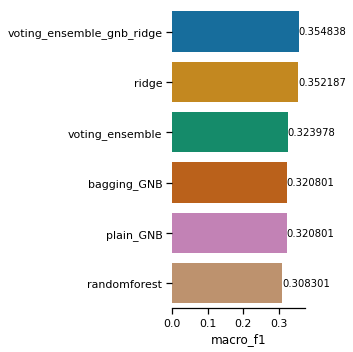

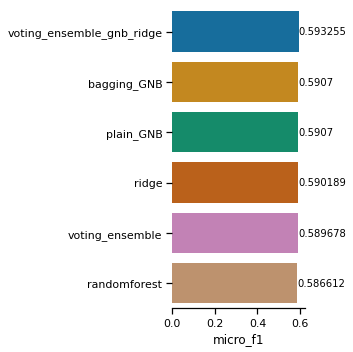

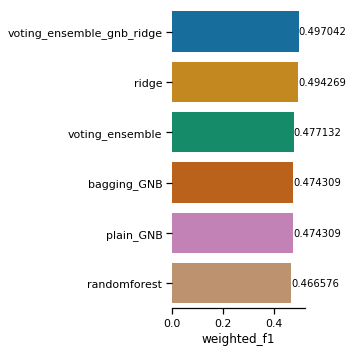

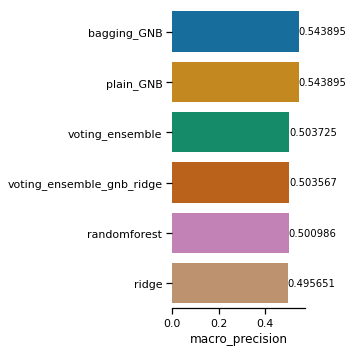

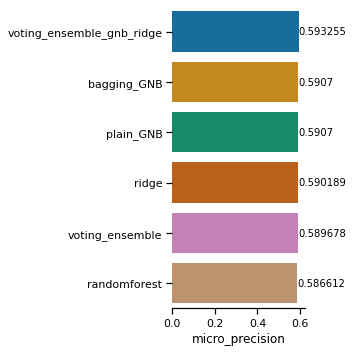

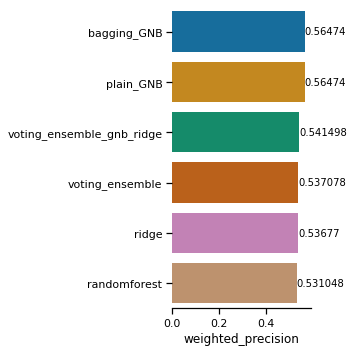

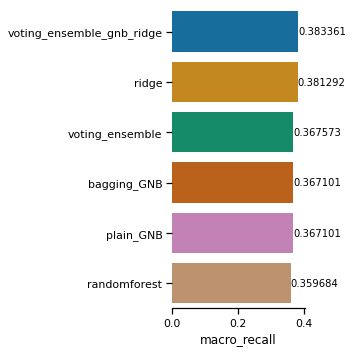

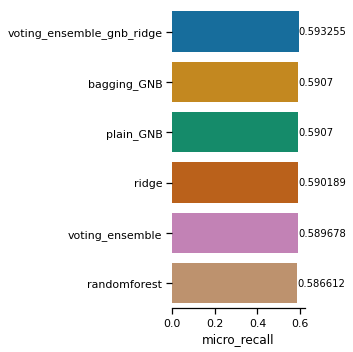

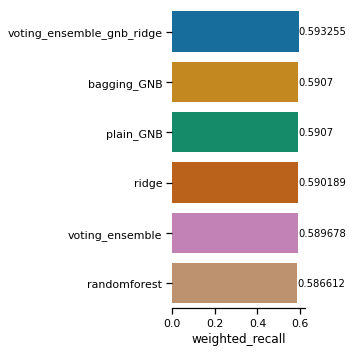

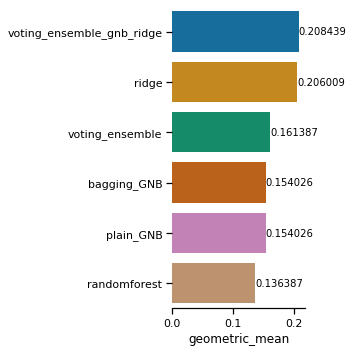

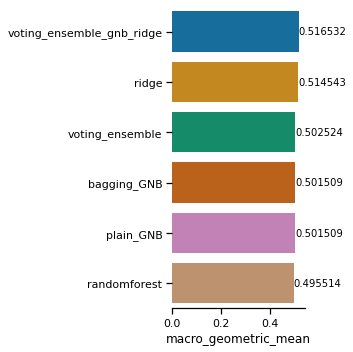

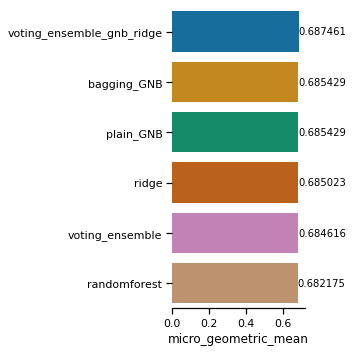

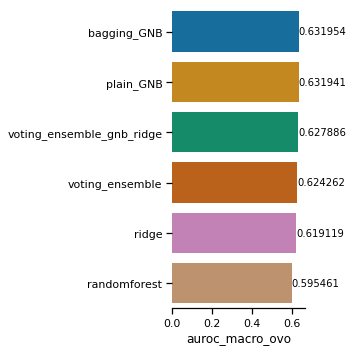

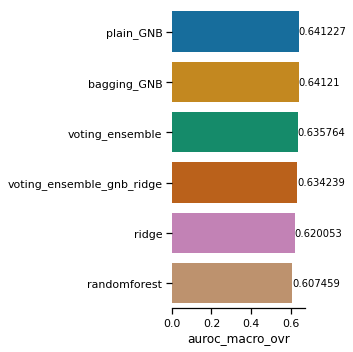

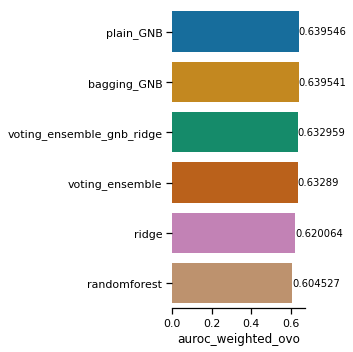

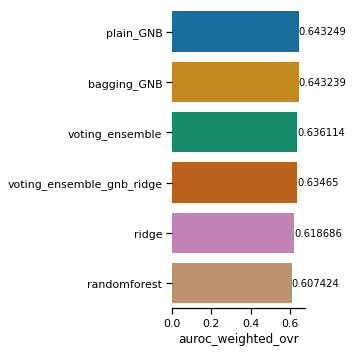

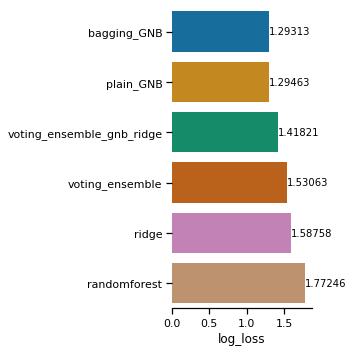

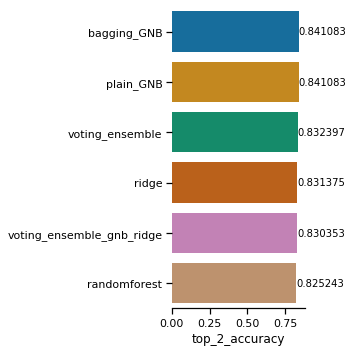

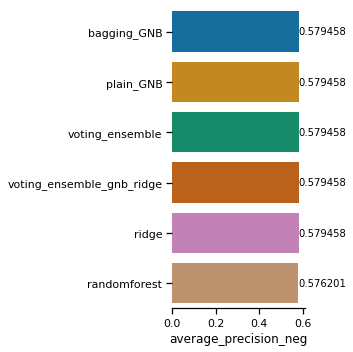

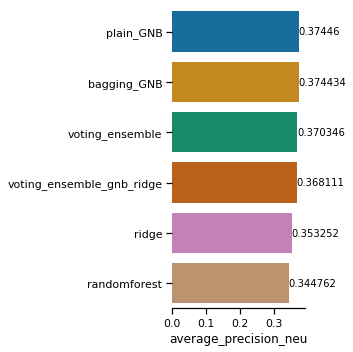

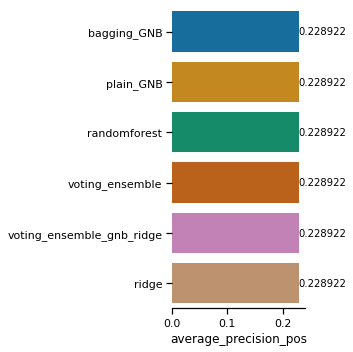

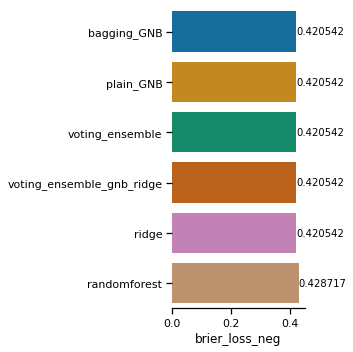

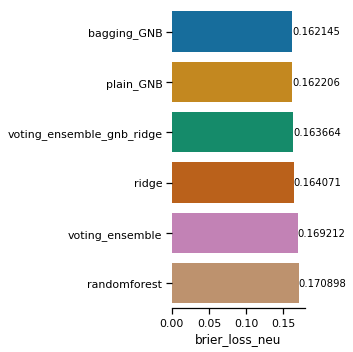

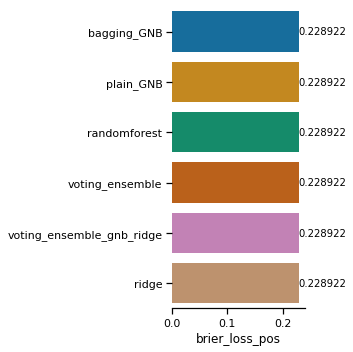

time: 9.15 s


In [9]:
# visualize
for metric in METRICS.keys():
    df = results_df.sort_values(by=metric, ascending="loss" in metric)
    g = sns.catplot(
        x=metric,
        y="model",
        data=df,
        kind="bar",
        linewidth=0,
        palette="colorblind",
    )
    ax = plt.gca()
    _ = ax.bar_label(ax.containers[0])
    sns.despine(left=True, top=True, right=True)
    _ = plt.ylabel("")
    plt.tight_layout()
    plt.show()
    del df
    del g
    del ax
    _ = gc_collect()

## By speaker gender

In [10]:
for model in tqdm(MODELS):
    results = score_model(
        model, "m_speaker", data.loc[labels.speaker_gender == "m", :], results
    )
for model in tqdm(MODELS):
    results = score_model(
        model, "f_speaker", data.loc[labels.speaker_gender == "f", :], results
    )

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names,

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names,

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

time: 15.9 s


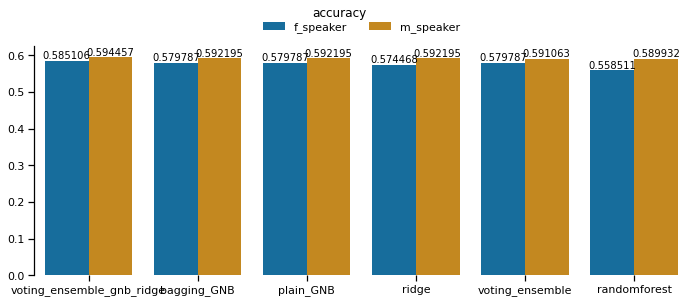

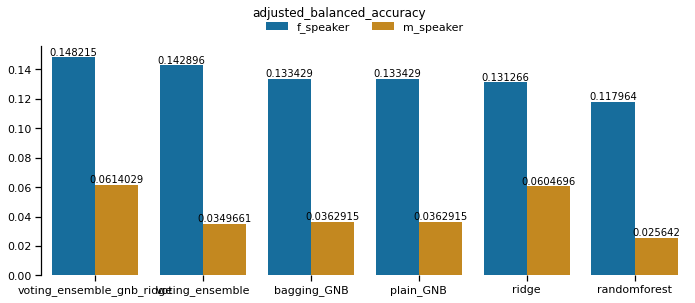

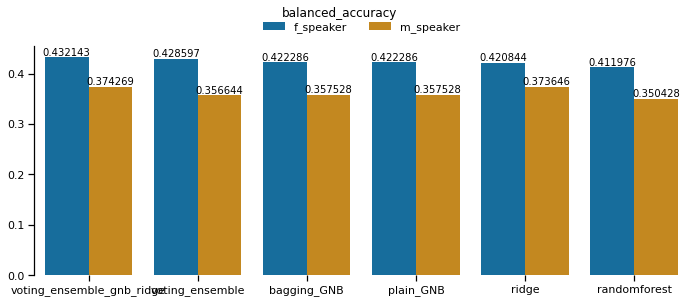

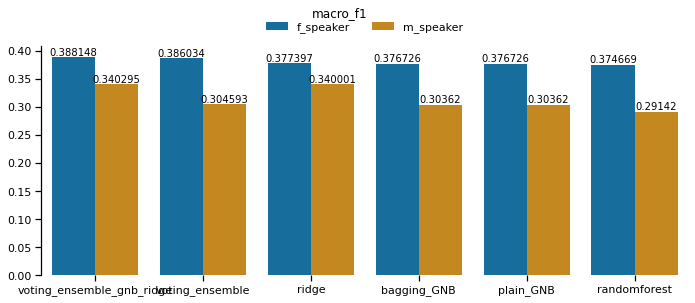

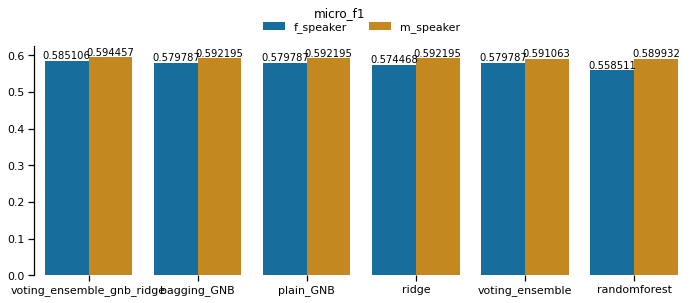

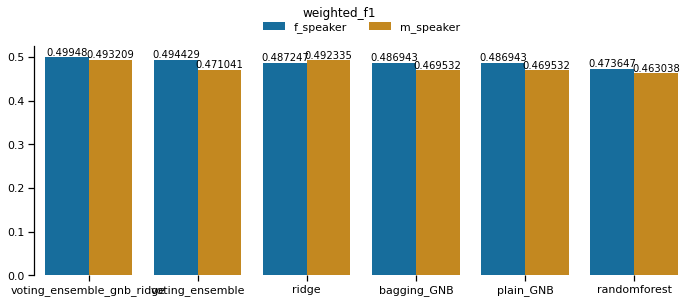

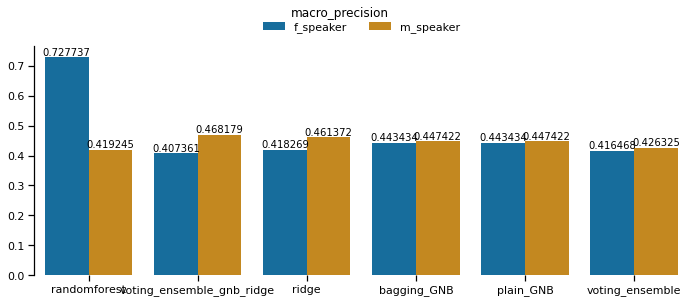

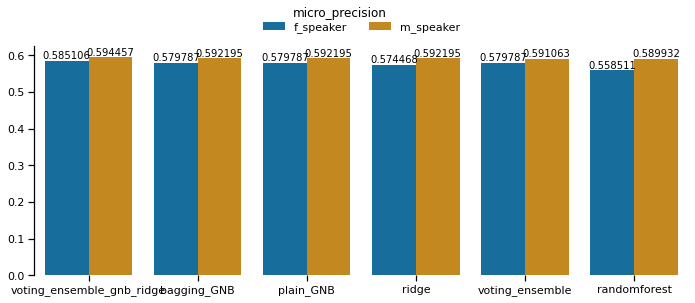

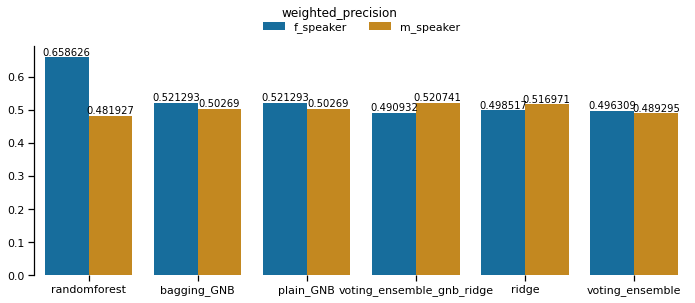

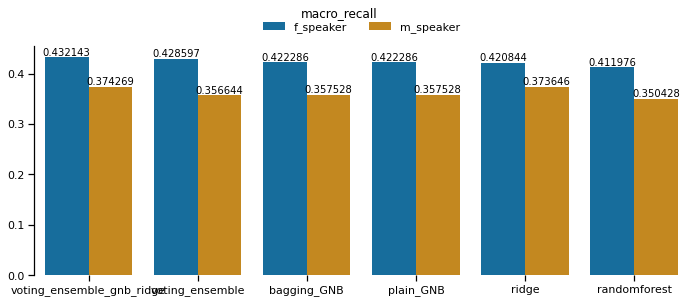

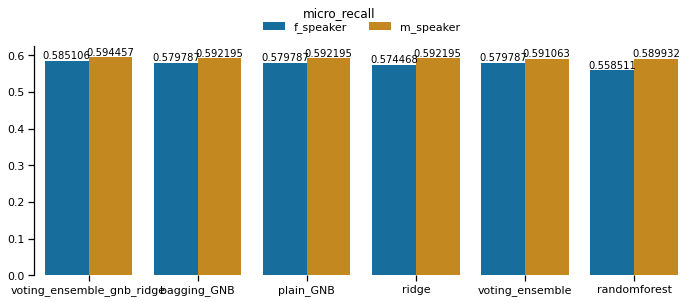

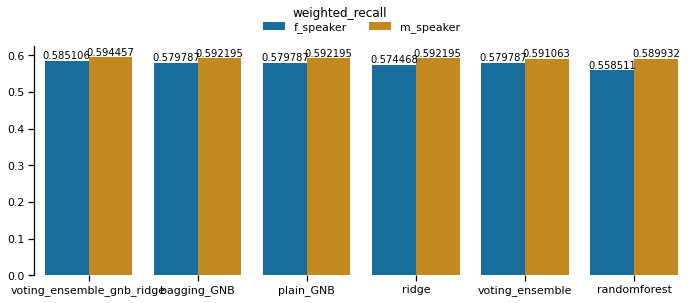

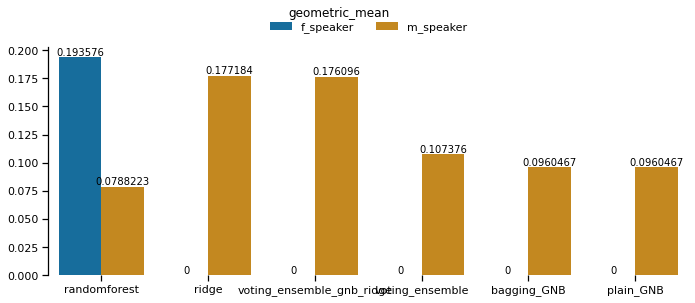

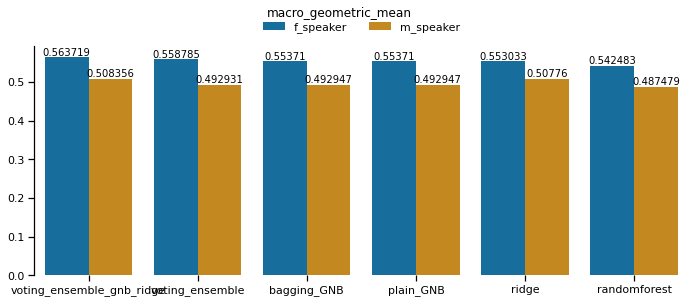

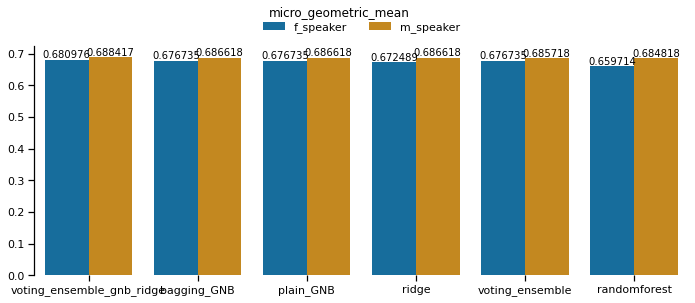

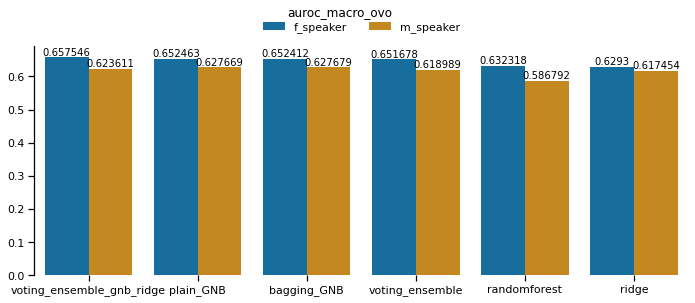

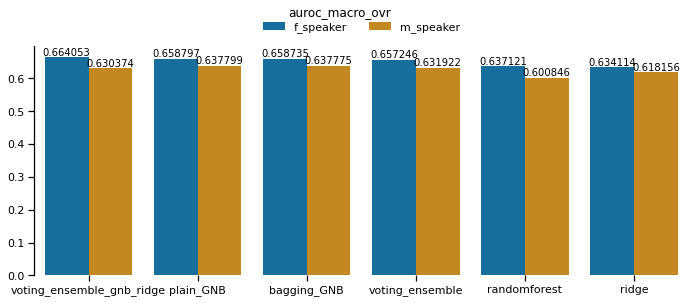

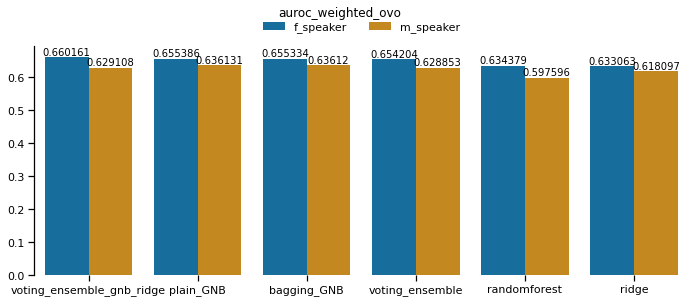

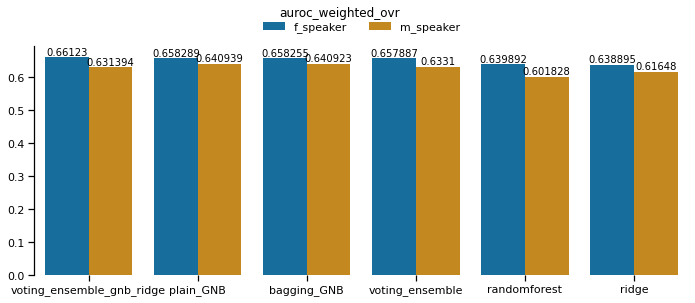

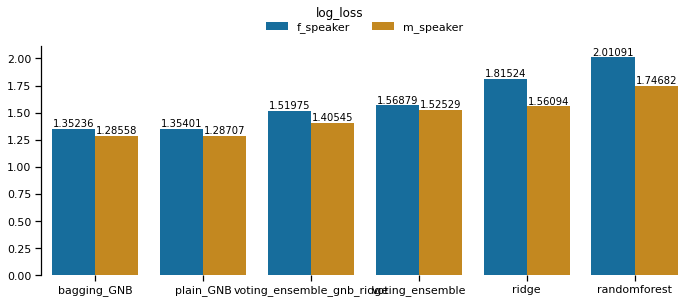

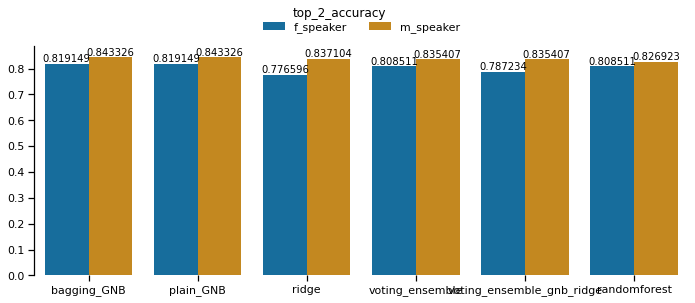

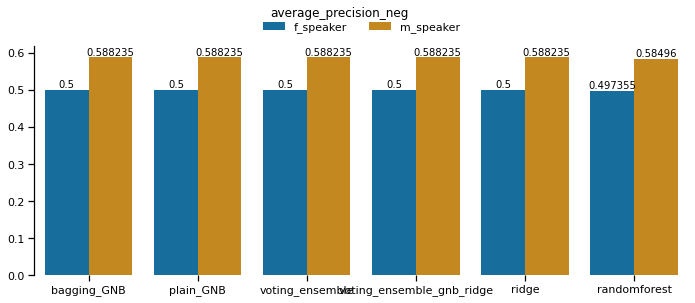

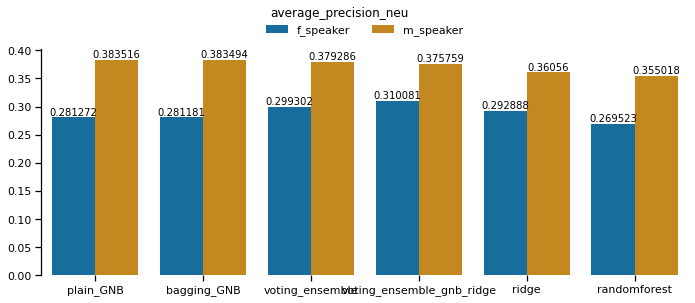

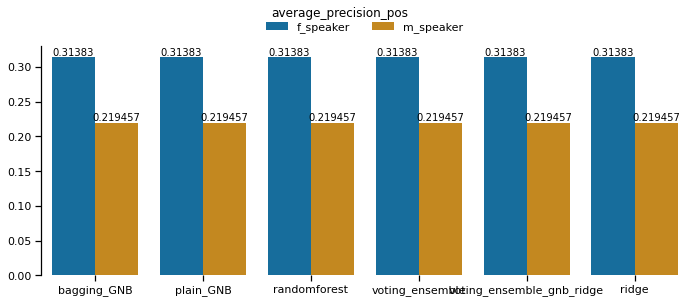

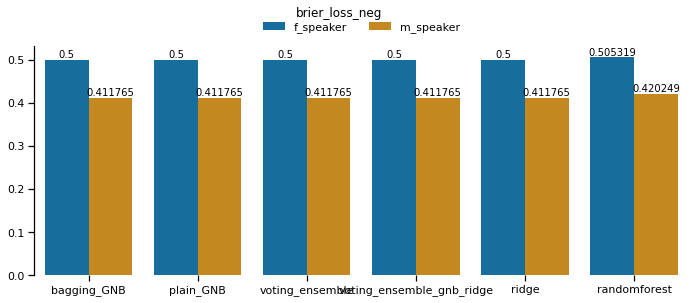

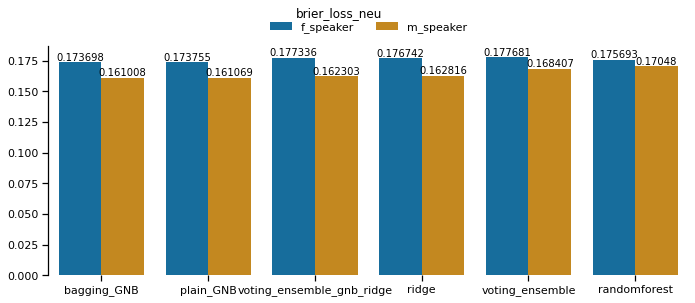

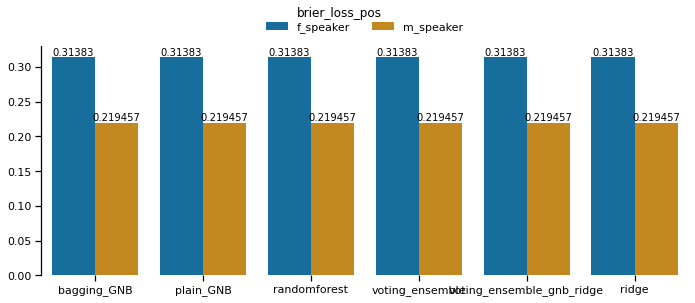

time: 10.2 s


In [11]:
results_df = pd.DataFrame(results)
results_df = results_df.loc[results_df.score_set.isin({"f_speaker", "m_speaker"}), :]
for metric in METRICS.keys():
    df = results_df.sort_values(by=metric, ascending="loss" in metric)
    g = sns.catplot(
        x="model",
        y=metric,
        data=df,
        kind="bar",
        hue="score_set",
        hue_order=["f_speaker", "m_speaker"],
        palette="colorblind",
        linewidth=0,
        height=4,
        aspect=2.5,
        legend=False,
    )
    sns.despine(top=True, bottom=True, right=True)
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    _ = plt.suptitle(metric, y=1.1)
    _ = plt.legend(
        bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=2, frameon=False
    )
    ax = plt.gca()
    for container in ax.containers:
        _ = ax.bar_label(container)
    plt.show()
    del df
    del g
    del ax
    _ = gc_collect()

## By language

This is roughly equivalent to the data source of the holdout sets. Note that x4nth055_SER_custom contains one sample in English, which is omitted in this section's analysis.

In [12]:
for model in tqdm(MODELS):
    results = score_model(model, "arb", data.loc[labels.lang1 == "arb", :], results)
for model in tqdm(MODELS):
    results = score_model(model, "deu", data.loc[labels.lang1 == "deu", :], results)
for model in tqdm(MODELS):
    results = score_model(model, "kor", data.loc[labels.lang1 == "kor", :], results)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names,

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


  0%|          | 0/27 [00:00<?, ?it/s]

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
Number of classes in y_true not equal to the number of columns in 'y_score'
y_true and y_pred contain different number of classes 2, 3. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 2]
y should be a 1d array, got an array of shape (156, 3) instead.


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names,

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names,

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

time: 19.6 s


The Arabic dataset only has two emotions (happy and neutral).

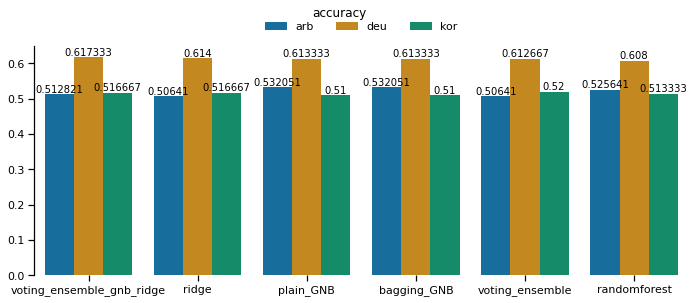

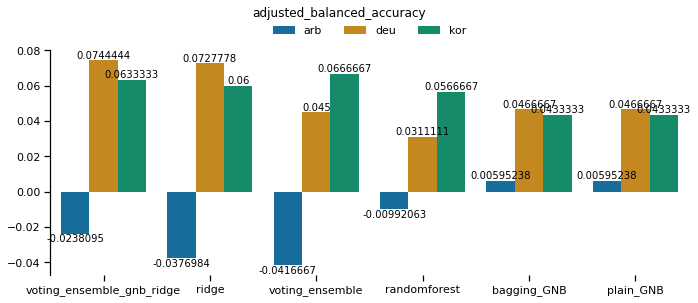

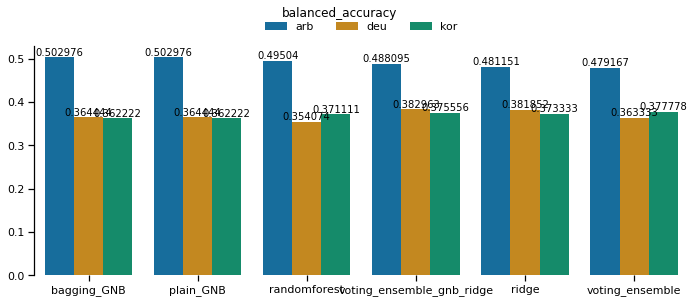

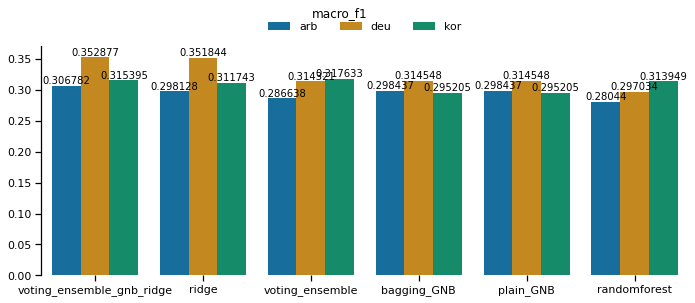

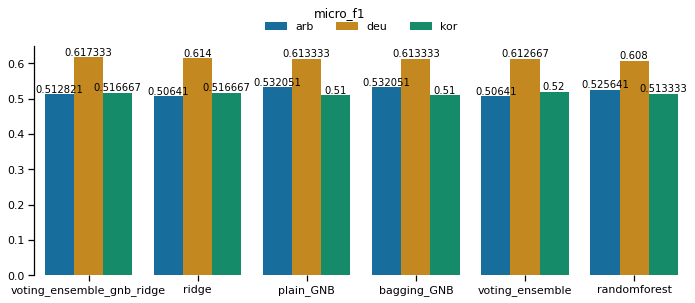

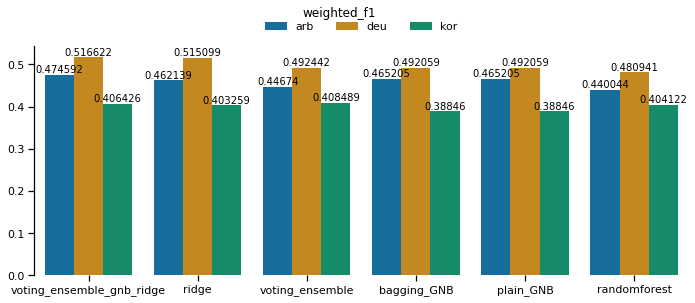

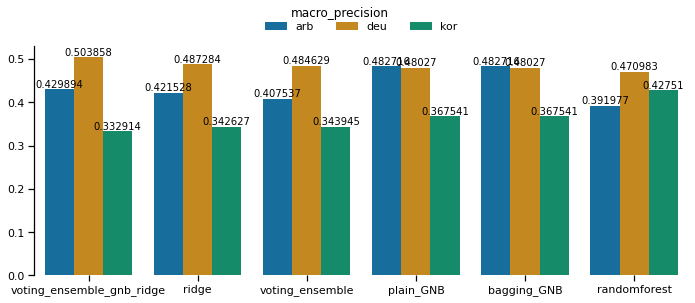

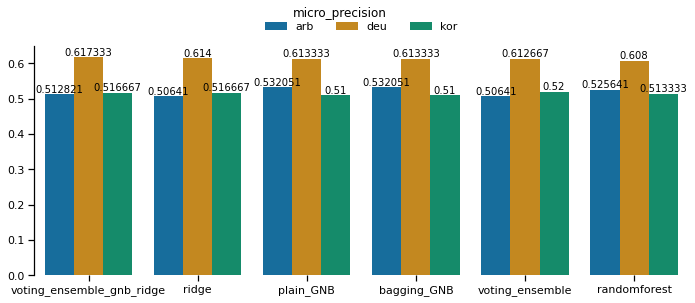

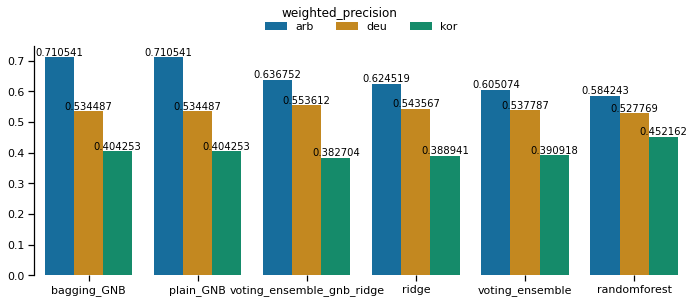

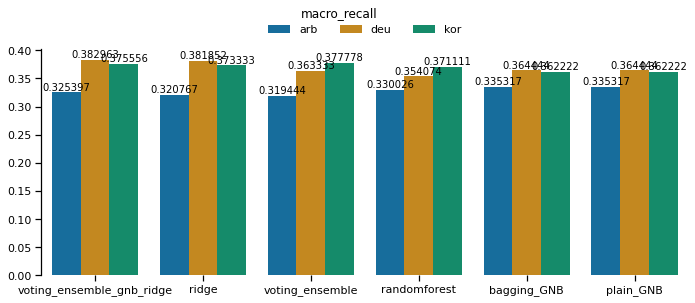

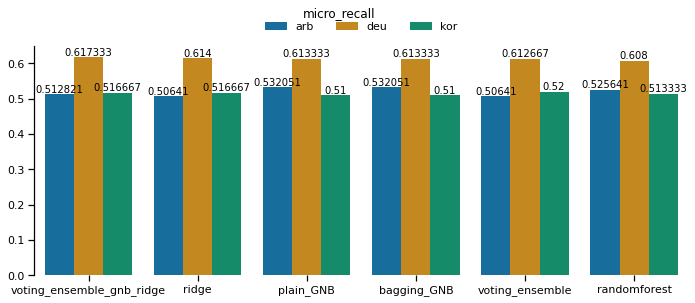

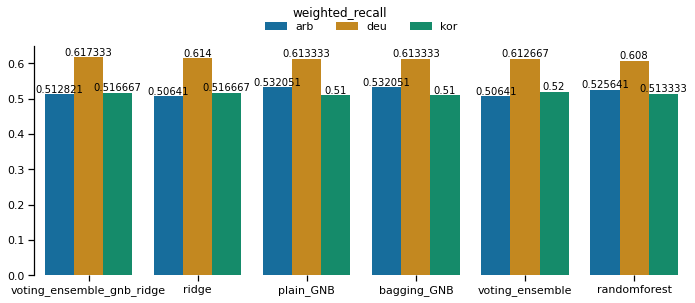

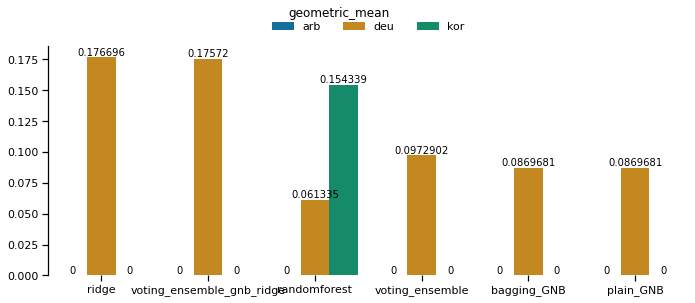

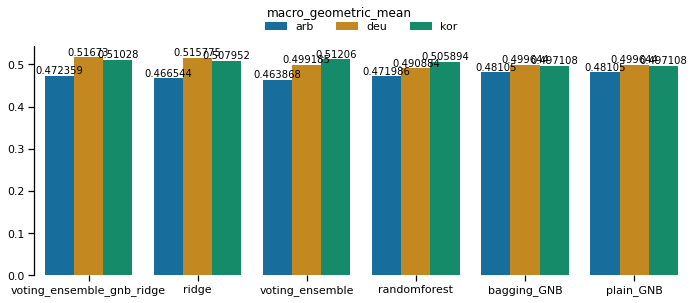

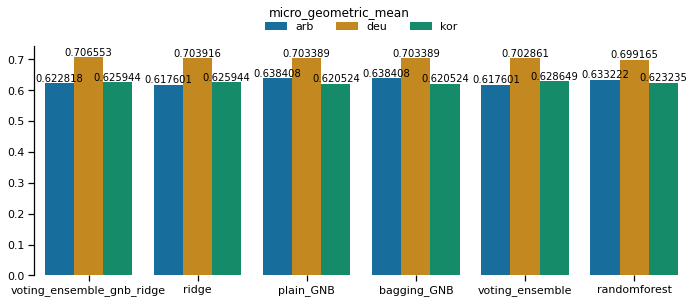

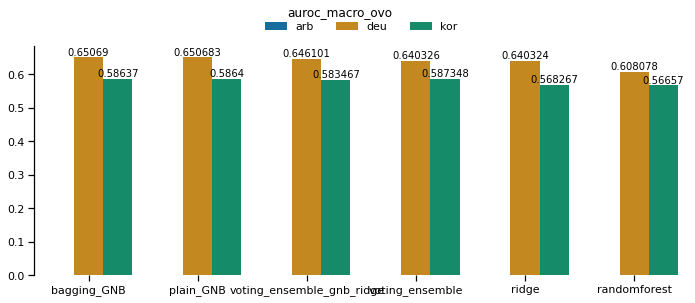

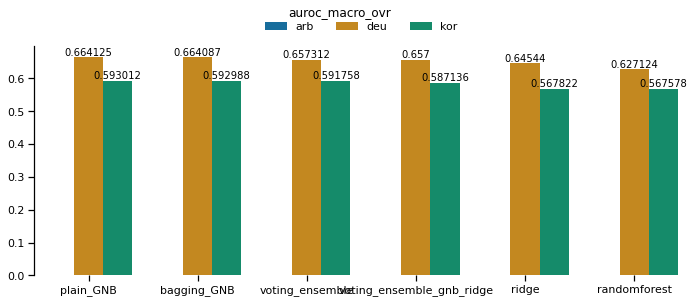

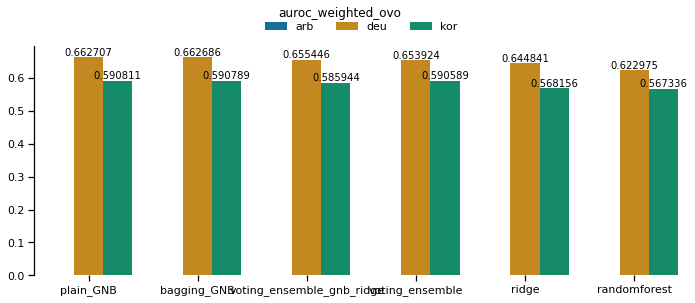

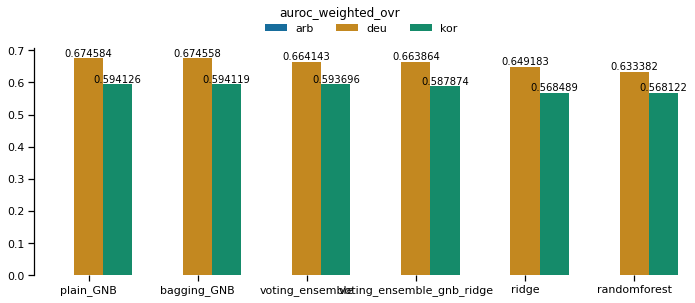

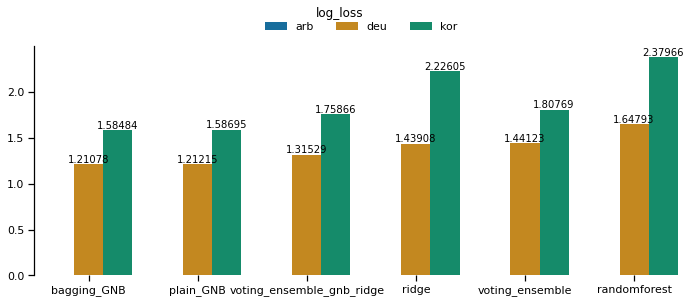

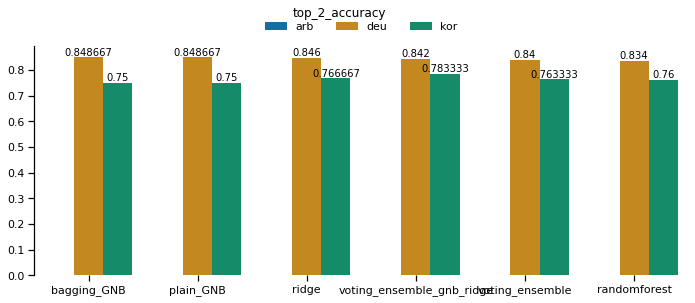

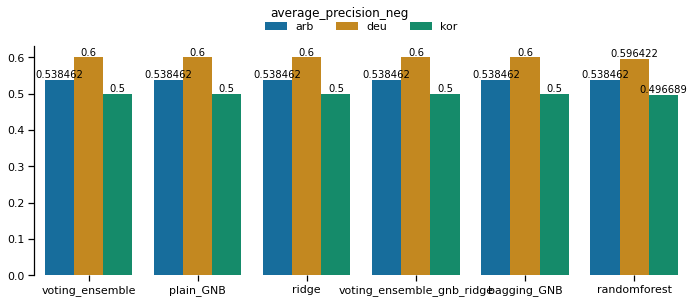

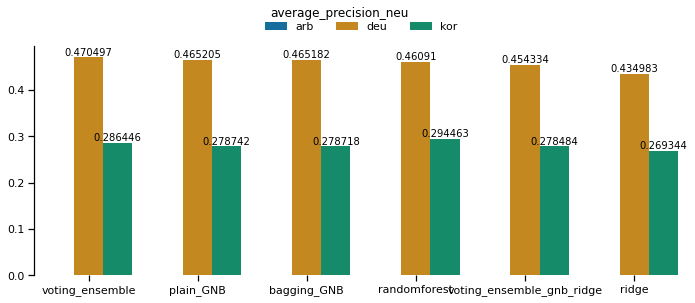

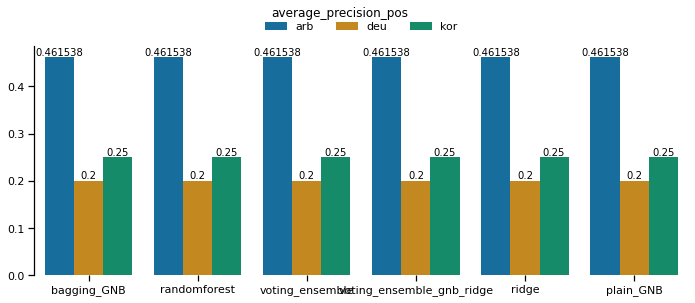

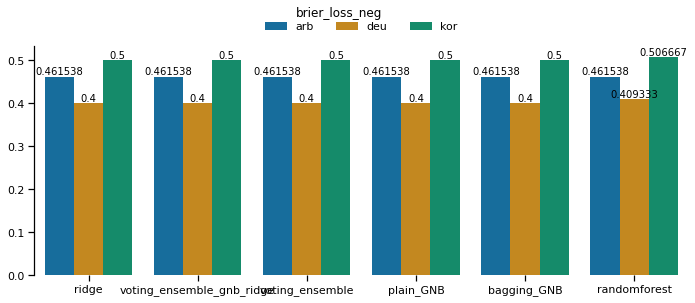

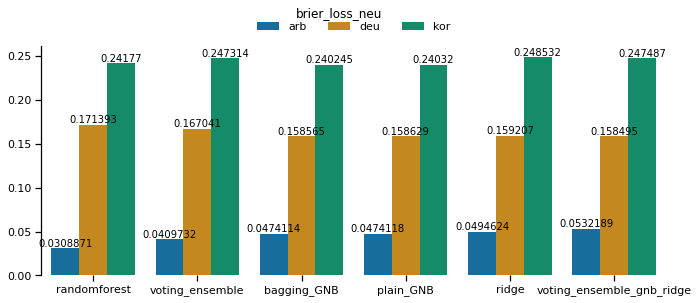

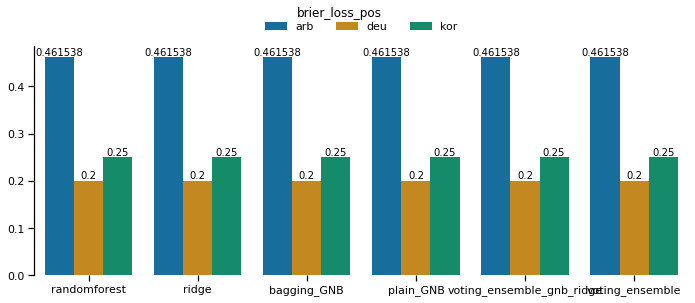

time: 11.6 s


In [13]:
results_df = pd.DataFrame(results)
results_df = results_df.loc[results_df.score_set.isin({"arb", "deu", "kor"}), :]
for metric in METRICS.keys():
    df = results_df.sort_values(by=metric, ascending="loss" in metric)
    g = sns.catplot(
        x="model",
        y=metric,
        data=df,
        kind="bar",
        hue="score_set",
        hue_order=["arb", "deu", "kor"],
        palette="colorblind",
        linewidth=0,
        height=4,
        aspect=2.5,
        legend=False,
    )
    sns.despine(top=True, bottom=True, right=True)
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    _ = plt.suptitle(metric, y=1.1)
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=3, frameon=False)
    ax = plt.gca()
    for container in ax.containers:
        _ = ax.bar_label(container)
    plt.show()
    del df
    del g
    del ax
    _ = gc_collect()

## By valence (OvR)

In [14]:
for valence in ("neg", "neu", "pos"):
    for model in tqdm(MODELS):
        results["model"].append(model)
        results["score_set"].append(valence)
        _ = model
        model = load_model(model)
        df = data.loc[:, GNB_FEATURES] if "GaussianNB" in str(model) else data
        y_pred = model.predict(df)
        y_prob = model.predict_proba(df)
        dump(y_prob, f"{OUT_FOLDER}/predictions/{_}_{valence}.pkl")
        del df
        del model
        _ = gc_collect()
        for metric, scorer in tqdm(METRICS.items()):
            if "average_precision" in metric or "brier_score" in metric:
                if metric[-3:] != valence:
                    results[metric].append(np.nan)
                    continue
            results[metric].append(
                binary_scorer(scorer, valence)(
                    y_true, y_prob if metric in PREDICT_PROBA_KEYS else y_pred
                )
            )

  0%|          | 0/6 [00:00<?, ?it/s]

['./predictions/bagging_GNB_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/plain_GNB_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


['./predictions/randomforest_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarni

['./predictions/voting_ensemble_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_ensemble_gnb_ridge_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/ridge_neg.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

['./predictions/bagging_GNB_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/plain_GNB_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


['./predictions/randomforest_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarni

['./predictions/voting_ensemble_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/voting_ensemble_gnb_ridge_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


['./predictions/ridge_neu.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

['./predictions/bagging_GNB_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/plain_GNB_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/randomforest_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/voting_ensemble_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/voting_ensemble_gnb_ridge_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

['./predictions/ridge_pos.pkl']

  0%|          | 0/27 [00:00<?, ?it/s]

time: 23.8 s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_ranking.py:1745: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\metrics\_

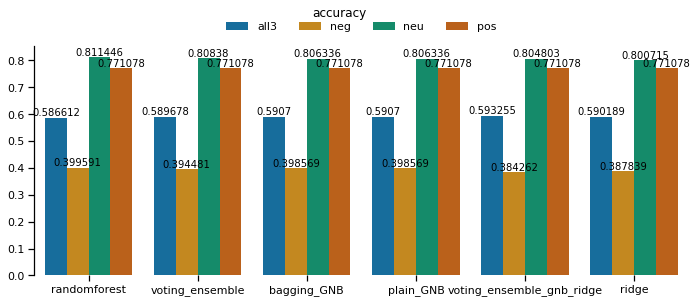

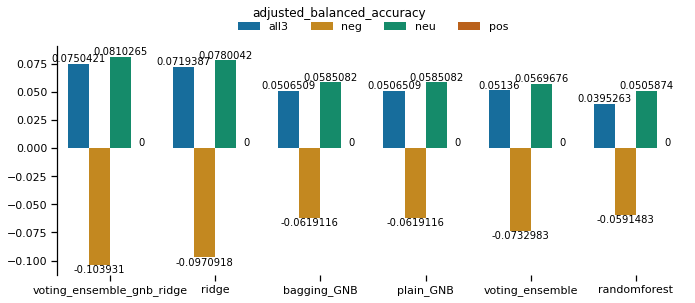

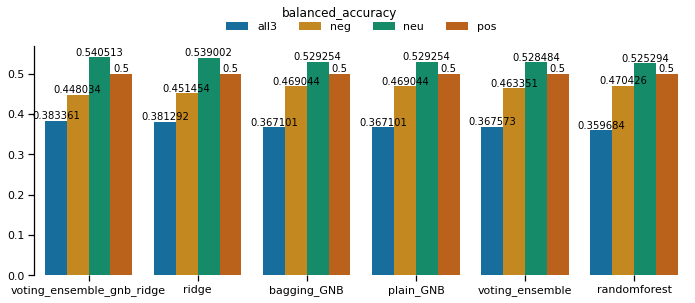

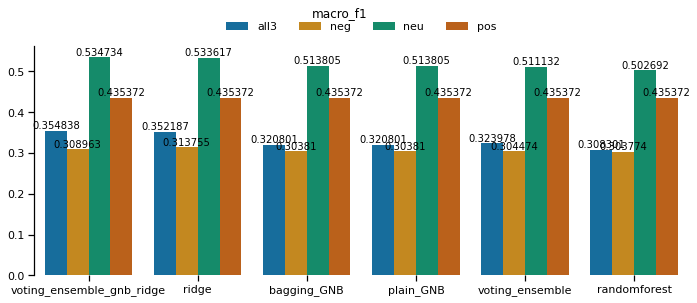

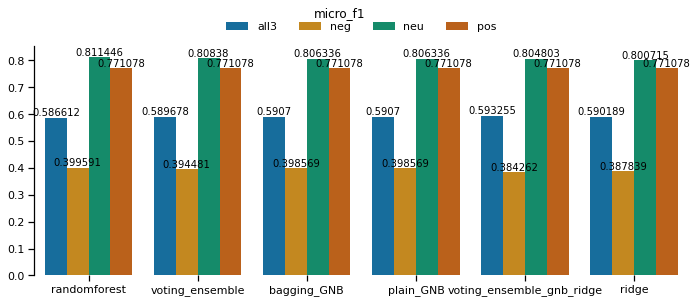

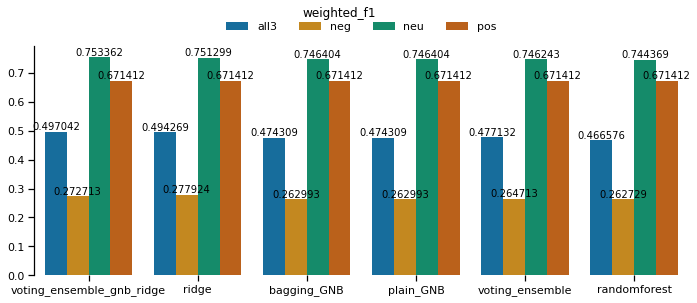

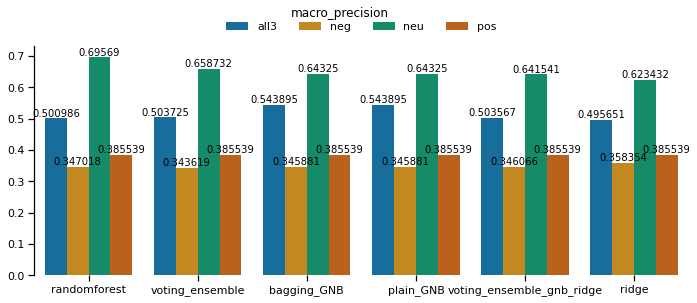

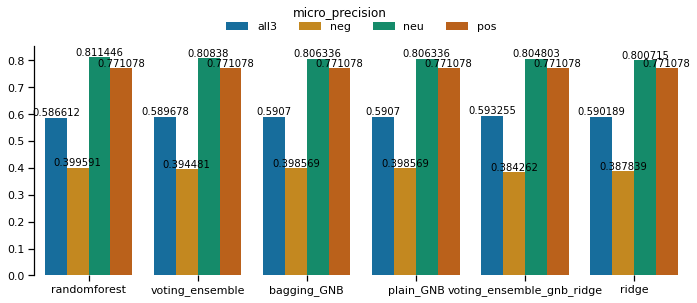

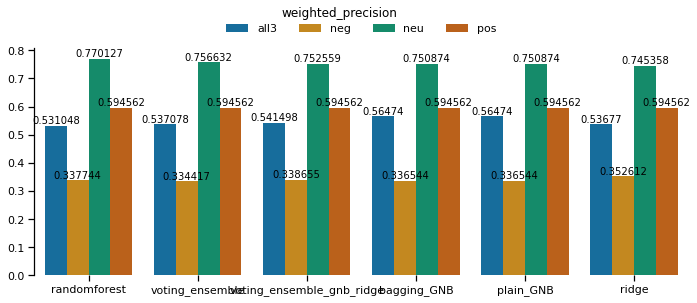

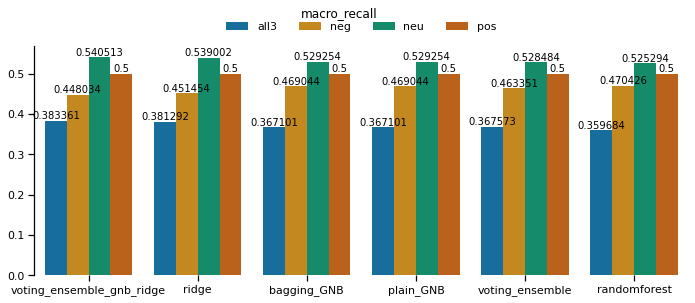

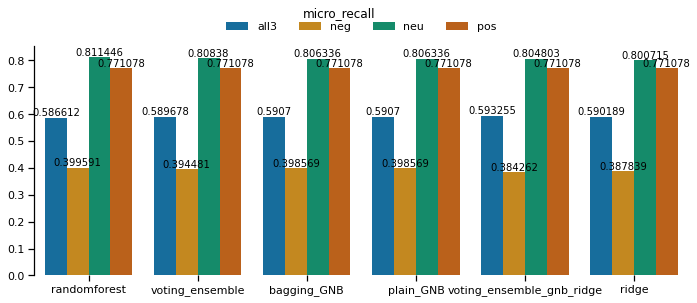

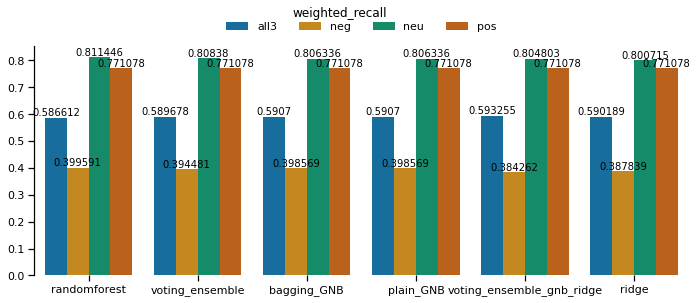

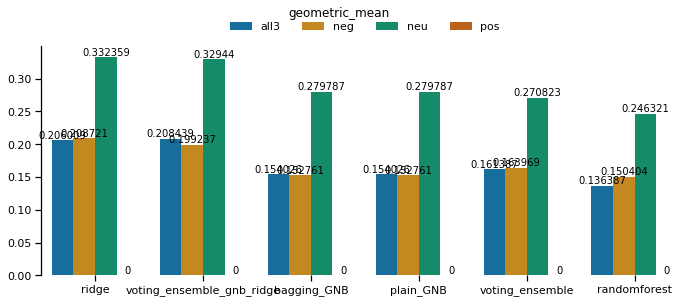

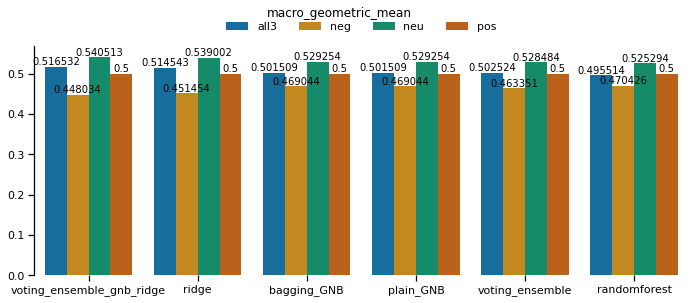

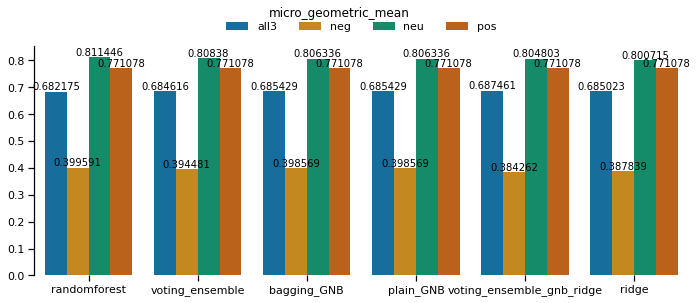

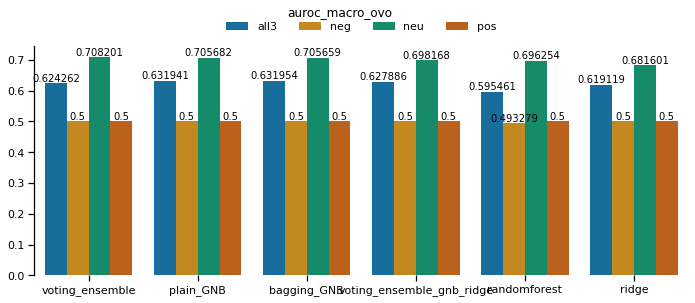

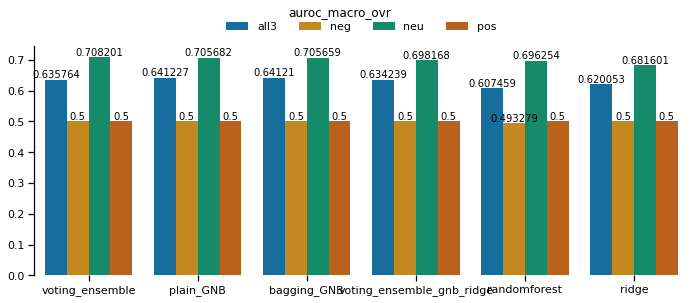

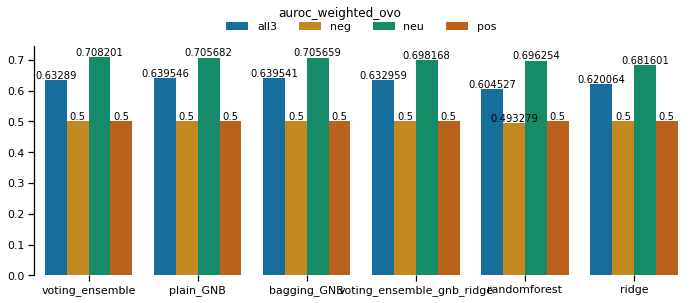

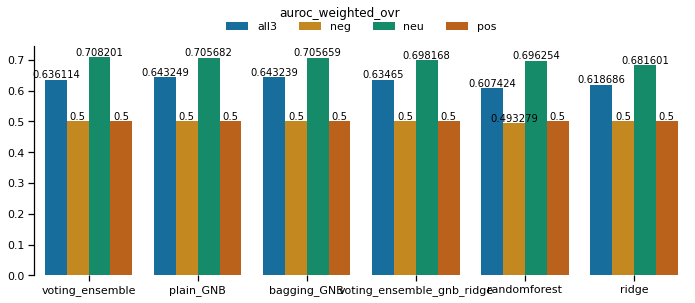

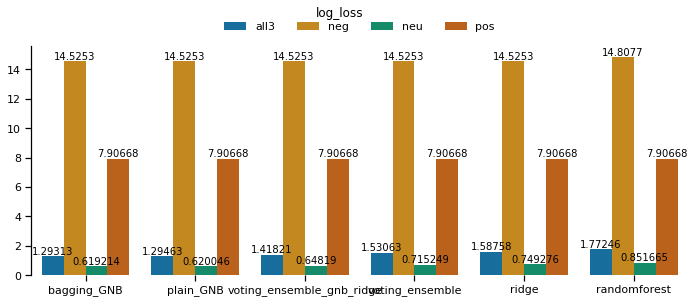

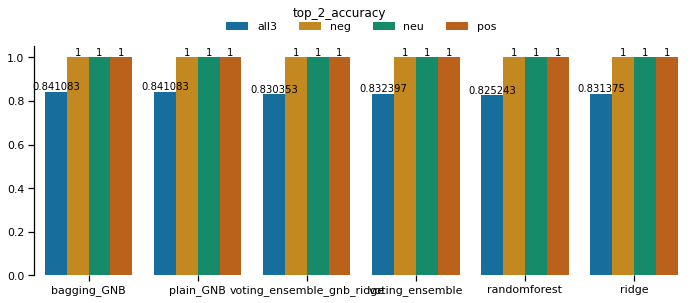

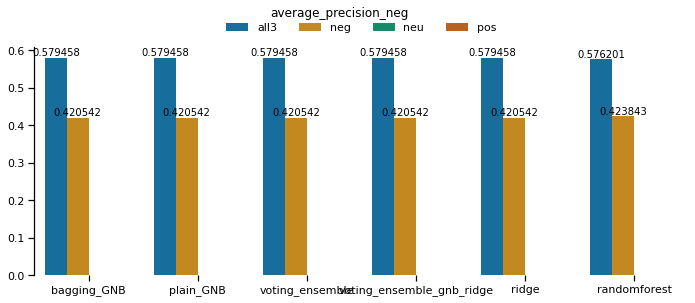

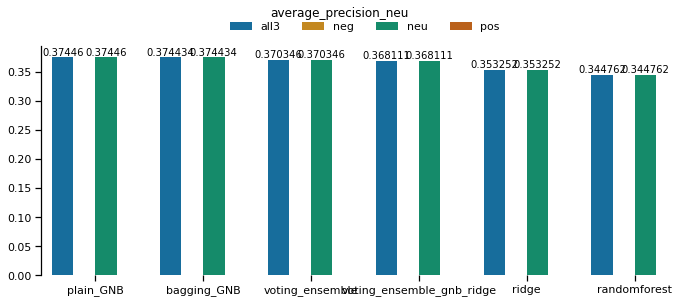

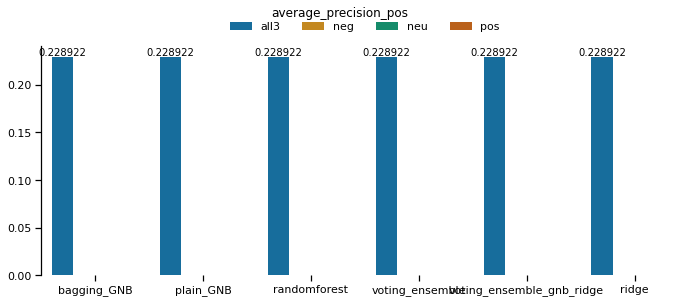

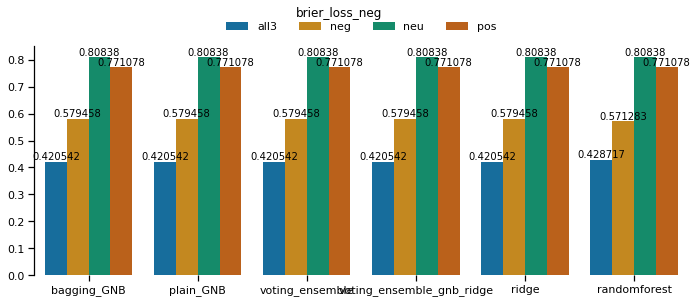

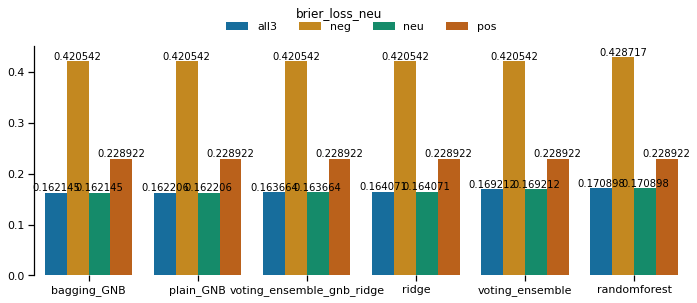

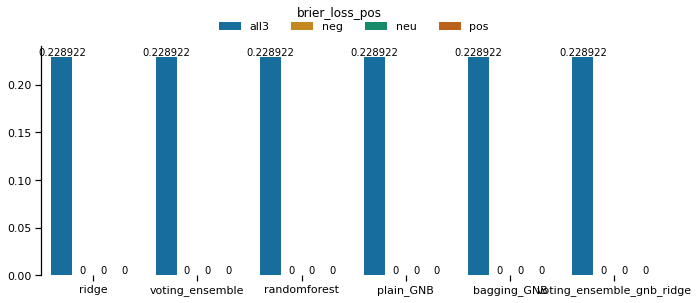

time: 12.8 s


In [15]:
results_df = pd.DataFrame(results)
results_df = results_df.loc[results_df.score_set.isin({"all3", "neg", "neu", "pos"}), :]
for metric in METRICS.keys():
    df = results_df.sort_values(by=metric, ascending="loss" in metric)
    g = sns.catplot(
        x="model",
        y=metric,
        data=df,
        kind="bar",
        hue="score_set",
        hue_order=["all3", "neg", "neu", "pos"],
        palette="colorblind",
        linewidth=0,
        height=4,
        aspect=2.5,
        legend=False,
    )
    sns.despine(top=True, bottom=True, right=True)
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    _ = plt.suptitle(metric, y=1.1)
    _ = plt.legend(
        bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=4, frameon=False
    )
    ax = plt.gca()
    for container in ax.containers:
        _ = ax.bar_label(container)
    plt.show()
    del df
    del g
    del ax
    _ = gc_collect()

# One English sample

This is a positive sample, so 2 would be a correct prediction.

In [16]:
df_ = data.loc[labels.lang1 == "eng", :]
for model in MODELS:
    df = df_
    if "GNB" in model:
        df = df_.loc[:, GNB_FEATURES]
    print(f"{model} predicted {load_model(model).predict(df)}")
del df
_ = gc_collect()
# correct prediction is 2

bagging_GNB predicted [0]
plain_GNB predicted [0]


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


randomforest predicted [0]


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names,

voting_ensemble predicted [0]
voting_ensemble_gnb_ridge predicted [0]
ridge predicted [0]
time: 4.27 s


In [17]:
results_df = pd.DataFrame(results)
results_df.columns = results_df.columns.astype(str)
results_df.reset_index(drop=True).to_csv(f"{OUT_FOLDER}/holdout_results.csv")

time: 9 ms


# Discussion

The OOB randomforest scores may have been a red herring; the leakage from feature extraction was just too much. The forest is clearly overfit.

On the other hand GNB displays much narrower discrepancy between training and holdout performance. The voting classifier is most performant by some measures too. So one of the first things I would do if I go back would be to train a Ridge classifier prototype and include that in an ensemble with GNB (maybe with RF too).

How surprising to see such poor performance distinguishing negative samples.

Overall, I am disappointed. There is a lot of room for improvement and many new approaches we could take with the data:
* resampling
* augmentation
* more FRILL-based engineering
* low-level audio features
* spectrograms/MFCCs
* deep learning

* best AUROC: 64.3% (plain_GNB)
* best accuracy: 59.3% (voting_ensemble_gnb_ridge)
* best log loss: 1.293 (bagging_GNB)

I'll probably use the bagging GNB.

In [18]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 130.07686829566956 s
time: 113 ms


[^top](#Contents)